# Catégoriser automatiquement des questions : OC projet 6 #

## Traitement de notre problématique: Modélisation par une approche supervisée  ##

Nous allons dans cette seconde partie adoptée une approche supervisée afin de construire notre moteur de recommendations de tags. Dans cette approche, nous retournerons 5 tags par questions et nous comparerons ce résultat aux tags rentrés par l'utilisateur. Nous utiliserons la même mesure que dans la partie non supervisée. Pour batîr cette seconde partie, nous adopterons deux approches classiques à notre problème qui peut être décrit comme un problème de classification multilabel (appartenance à plusieurs classes) et multiclasse.

La première approche conistera à adopter la méthode binary relevance où un classifieur est entrainé pour chacun des classes sélectionnées (nos tags). La seconde approche consistera à utiliser un classifieur intraséquement multilabel (RandomForest). Nous comparerons ces approches en terme de performance et de temps de calcul.

## I - Importation des librairies et définition des fonctions: ##

In [91]:
import pandas as pd
import numpy as np
import nltk


from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import pickle
import auxiliary as aux

In [92]:
def line_treatment(line, list_words, tokenizer):
    """ Fonction qui traite une liste de mots en entrée
    et ressort un bag of words avec RegexTokenizer
    """
    list_to_include = []
    list_to_drop = []
    line = line.lower()
    for mot in list_words:
        if(mot in line.lower()):
            list_to_include.append(mot)
            list_to_drop.append(tokenizer.tokenize(mot)[0])
    
    vocab = tokenizer.tokenize(line)
    
    for inc in list_to_include:
        for w in vocab:
            if(w == tokenizer.tokenize(inc)[0]):
                vocab.remove(w)
                vocab.append(inc)
    return vocab

In [93]:
def remove_stopwords(vocab):
    """ Fonction qui traite les stopwords
    contenues dans la chaine de mots vocab
    """
    total_list = list(stopwords.words("English"))
    custom_list = ["to", "use", "can", "the", "get", "is", "doe", "way", "two"
                  "one", "an", "there", "are", "new", "like", "using", "vs", "without"]
    total_list = total_list + custom_list
    vocab_copy = vocab.copy()
    for w in vocab:
        if w in total_list:
            vocab_copy.remove(w)
    vocab_copy2 = vocab_copy.copy()
    for w in vocab_copy:
        if len(w) < 2:
            vocab_copy2.remove(w)
    return vocab_copy2

In [94]:
def get_wordnet_pos(w, treebank_tag, list_t):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            if(len(w)<13):
                return wordnet.NOUN
            else:
                return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun if it belows to list_t
            if (w in list_t):
                return wordnet.NOUN
            else:
                return wordnet.VERB

In [95]:
def lemm_fonction(tokens, list_t):
    """ Fonction qui renvoie une liste lemmatizer"""
    lemm = []
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(tokens)
    for word, tag in tagged:
        wntag = get_wordnet_pos(word, tag, list_t)
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        if wntag == wordnet.NOUN:
            lemm.append(lemma)
    return lemm

In [96]:
def tokenizer_idf(text):
    """Tokenizer traitant nos données d'entrée de tf_idf
    """
    capwork_tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    list_words_to_keep = [".net", "c++", "c#","sql-server", "asp.net", 
                          'ruby-on-rails', 'objective-c', 'visual-studio']
    response = line_treatment(text, list_words_to_keep, capwork_tokenizer)
    response3  = lemm_fonction(response, list_real_tags)
    return remove_stopwords(response3)

In [97]:
def traitement_des_tags(list_to_treat, list_tags):
    """ Fonction qui renvoie la liste des tags filtrées 
    et ordonnées
    """
    for element in list_to_treat:
        list_to_treat = set(list_to_treat)
        if (element not in list_tags):
            list_to_treat.remove(element)
        list_temp = list(list_to_treat)
    return sorted(list_temp)

In [98]:
def get_tag_from_proba(response_vect, nb_tag, labelizer):
    """ Fonction qui renvoie les tags correspondants
    en fonction des probabilités obtenues et du nombre
    de tags désirés
    """
    list_response = [list(labelizer.classes_[resp.argsort()[-1: -nb_tag - 1: -1]])
                     for resp in response_vect]
    return list_response

In [99]:
def get_tagging_score(y_tag_true, y_tag_predit):
    """ Fonction qui renvoie le nombre de tags vrai
    prédit dans la liste prédite"""
    score_test = list()
    for (x, y) in zip(y_tag_true, y_tag_predit):
        score_test.append(len(set(x) & set(y))/len(set(x)))
    return sum(score_test)/len(score_test)

## II - Importation de notre jeu de données: ##

Nous récupérerons directement le jeu de données issu des traitements de notre exploration de données.

In [100]:
table_model = pd.read_json("table_model.json")

In [101]:
bow_tags = [y for x in table_model["Tags"] for y in x]
f_dist_tags = nltk.FreqDist(bow_tags)
list_real_tags = list(f_dist_tags)

## III - Exploration supervisée à partir des tags existants : ##

### Traitements des tags : ###

Sélection des NB_TAGS les plus courants. Nous prendrons par défaut la valeur de 80 tags, ces 80 tags les plus fréquents sont au moins présent dans 260 questions de notre jeu de données, ce qui nous assure un nombre de questions suffisant pour l'apprentissage. Nous supprimerons les autres tags de notre jeu de données.

In [102]:
NB_TAGS = 80
list_tags = [x for (x,_) in f_dist_tags.most_common(NB_TAGS)]

In [103]:
table_model["Tags"] = table_model["Tags"].apply(lambda x: traitement_des_tags(x, list_tags))
table_model["Tags"] = table_model["Tags"].apply(lambda x: np.nan if len(x)==0 else x)
table_model.dropna(axis = 0, how="any", subset = ["Tags"], inplace=True)

### Transformation des données cibles en vecteur de label : ###

Nous allons transformer nos valeurs de sortie afin de représenter l'appartenance à chacune des classes par un 0 ou un 1 dans un vecteur de dimension correspondant au nombre de tags sélectionnés.

In [104]:
mlb = MultiLabelBinarizer(sparse_output=False)
y_tags = mlb.fit_transform(table_model["Tags"])

In [105]:
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'arrays', 'asp.net',
       'asp.net-mvc', 'bash', 'c', 'c#', 'c++', 'cocoa', 'cocoa-touch',
       'css', 'database', 'datetime', 'debugging', 'delphi', 'design',
       'design-patterns', 'django', 'eclipse', 'exception', 'file',
       'generics', 'git', 'hibernate', 'html', 'http', 'image', 'iphone',
       'java', 'javascript', 'jquery', 'json', 'language-agnostic', 'linq',
       'linux', 'list', 'macos', 'math', 'multithreading', 'mysql',
       'objective-c', 'oop', 'oracle', 'parsing', 'performance', 'perl',
       'php', 'python', 'reflection', 'regex', 'ruby', 'ruby-on-rails',
       'security', 'spring', 'sql', 'sql-server', 'sql-server-2005',
       'string', 'svn', 'swing', 'tsql', 'unit-testing', 'unix',
       'user-interface', 'vb.net', 'version-control', 'vim',
       'visual-studio', 'visual-studio-2008', 'wcf', 'web-services',
       'winapi', 'windows', 'winforms', 'wpf', 'xcode', 'xml'], dtype=object)

### Transformation des documents en bag of words: tf_idf###

Nous allons effectué une transformation de nos documents en une matrice de mots en utilisant la méthode TF-IDF tenant compte à la fois du taux de fréquence de chacun des mots rencontrés ainsi que de son taux de présence dans chacun des documents. Notre corpus de 49 745 questions sera ainsi chacun représenté par un vecteur de taille 1930 (correspondant au nombre de mots dans le vocabulaire retenu) dont le contenu représentera le score tf_idf du mot en question.

In [151]:
table_model["BodyTitle"].shape

(49745,)

#### Paramétrages du tf_idf : ####

Nous allons conserver les mots dont le taux de fréquence dans les documents est de 0.1% (environ 50 questions) à 20% (environ 10000 questions). Ce choix est important car il permet de sélectionner la richesse du vocabulaire utilisée pour décrire chacun des documents. Ce choix a également un impact non négligeable en terme de temps de calcul.

In [106]:
Vectorizer = TfidfVectorizer(input='content', stop_words="english", tokenizer=tokenizer_idf, min_df=0.001, max_df=0.2)

In [107]:
doc = Vectorizer.fit_transform(table_model["BodyTitle"])

In [108]:
len(Vectorizer.get_feature_names())

1930

In [164]:
#df = pd.DataFrame(columns=["idf_score","mots"])
#df["mots"] = [Vectorizer.get_feature_names()[x] for x in Vectorizer.idf_.argsort()]
#df["idf_score"] = Vectorizer.idf_[Vectorizer.idf_.argsort()]

#df[-100:-1]

In [18]:
outfile = open("tf_idf_transformation_2.pyc", 'wb')
pickle.dump(doc, outfile)
outfile.close()

### Séparation du jeu de données en jeu d'entrainement et jeu de test : ###

Nous allons séparé notre jeux de données en jeux d'entrainement et jeux de données.

In [109]:
tfidf_train, tfidf_test, y_tags_train, y_tags_test  = train_test_split(doc, y_tags, test_size=0.3)

### Prédiction avec un classifier de type MultinomialNB: ###

Nous allons dans un premier temps utiliser un classifier naif afin d'entrainer notre premier modèle et estimer son score sur le jeu de test ainsi que sur le jeu de test en généralisation afin d'évaluer sa qualité.

In [110]:
clf_naive_bayes = MultinomialNB()

In [111]:
parameters = {"estimator__alpha":[0.2, 0.5, 0.8, 1]}

In [112]:
ovr_bayes = OneVsRestClassifier(clf_naive_bayes)

In [113]:
NB_model = GridSearchCV(ovr_bayes, param_grid=parameters, cv=5)
NB_model.fit(tfidf_train, y_tags_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__alpha': [0.2, 0.5, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [114]:
response = NB_model.predict_proba(tfidf_test)

In [115]:
NB_model.best_params_

{'estimator__alpha': 0.2}

In [116]:
NB_model.best_score_

0.13945607535682492

In [117]:
df_response = pd.DataFrame(data = {"predit": get_tag_from_proba(response, 3, mlb), 
                                   "vrai tag": mlb.inverse_transform(y_tags_test)})
df_response

,predit,vrai tag
0,"[c++, java, c#]","(c++,)"
1,"[jquery, javascript, html]","(jquery,)"
2,"[c#, arrays, php]","(perl,)"
3,"[c, c++, c#]","(c,)"
4,"[java, c#, .net]","(java,)"
5,"[c#, windows, .net]","(c#,)"
6,"[java, c#, .net]","(java,)"
7,"[java, spring, .net]","(java,)"
8,"[c#, c++, .net]","(c#,)"
9,"[svn, version-control, windows]","(version-control,)"


In [171]:
print(f"Score sur le jeu de test: {round(get_tagging_score(df_response['vrai tag'], df_response['predit'])*100, 2)} %")

Score sur le jeu de test: 74.23 %


In [119]:
table_eval = pd.read_json("table_eval.json")
tf_eval = Vectorizer.transform(table_eval["BodyTitle"])


In [120]:
response_eval1 = NB_model.predict_proba(tf_eval)

In [121]:
response_eval = pd.DataFrame(data = {"predit" : get_tag_from_proba(response_eval1, 5, mlb), "vrai tag": table_eval["Tags"]})
response_eval

,predit,vrai tag
10003,"[git, python, windows, java, svn]","[python, setuptools, pip]"
10006,"[python, javascript, jquery, c#, list]","[python, iteration]"
1001,"[java, eclipse, svn, unit-testing, version-con...","[java, android, maven]"
10012,"[ruby, datetime, ruby-on-rails, c#, python]","[ruby-on-rails, xml, datetime]"
10017,"[javascript, json, c#, jquery, php]",[json]
10023,"[iphone, objective-c, python, cocoa-touch, php]","[iphone, objective-c, modalviewcontroller, vie..."
10026,"[c#, asp.net, .net, java, javascript]","[javascript, html5, google-chrome, manifest, r..."
10042,"[git, svn, version-control, ruby-on-rails, vis...","[git, github, git-svn]"
10052,"[asp.net-mvc, asp.net, c#, .net, php]",[asp.net-mvc-3]
10060,"[c#, javascript, c++, arrays, c]",[javascript]


In [122]:
get_tagging_score(response_eval["vrai tag"], response_eval["predit"] )

0.3711810098976711

### Prédiction avec un classifier de type Logistic Regression: ###

In [123]:
clf_lr = LogisticRegression()
parameters_lr = {"estimator__penalty":["l1","l2"],"estimator__C":[0.01, 0.1, 1, 10]}
ovr_log_reg = OneVsRestClassifier(clf_lr)

In [124]:
log_reg_model = GridSearchCV(ovr_log_reg, param_grid=parameters_lr, cv=5, return_train_score=True)
log_reg_model.fit(tfidf_train, y_tags_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__penalty': ['l1', 'l2'], 'estimator__C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [125]:
log_reg_model.best_params_

{'estimator__C': 10, 'estimator__penalty': 'l2'}

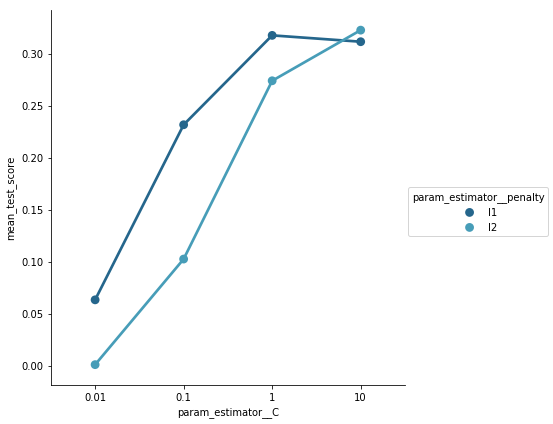

In [126]:
df_results = pd.DataFrame(log_reg_model.cv_results_)[["mean_test_score",
                                                "param_estimator__penalty",
                                                "param_estimator__C"
                                                 ]]
sns.factorplot(x="param_estimator__C", y="mean_test_score", hue="param_estimator__penalty", 
               data=df_results, capsize=.2, 
               palette="YlGnBu_d", size=6, aspect=1)
plt.show()

In [92]:
outfile = open("log_reg_ovr_model_2.pyc", 'wb')
pickle.dump(log_reg_model, outfile)
outfile.close()

In [127]:
response2 = log_reg_model.predict_proba(tfidf_test)

In [128]:
df_response2 = pd.DataFrame(data = {"predit": get_tag_from_proba(response2, 3, mlb), 
                                    "vrai tag": mlb.inverse_transform(y_tags_test)})
df_response2

,predit,vrai tag
0,"[c++, c, c#]","(c++,)"
1,"[jquery, javascript, html]","(jquery,)"
2,"[c#, arrays, php]","(perl,)"
3,"[c, linux, c++]","(c,)"
4,"[java, .net, arrays]","(java,)"
5,"[c#, windows, .net]","(c#,)"
6,"[java, swing, exception]","(java,)"
7,"[spring, java, security]","(java,)"
8,"[.net, c++, c#]","(c#,)"
9,"[svn, version-control, language-agnostic]","(version-control,)"


In [129]:
get_tagging_score(df_response2["vrai tag"], df_response2["predit"])

0.784046948985971

In [130]:
response_eval2 = log_reg_model.predict_proba(tf_eval)

In [131]:
response_eval2 = pd.DataFrame(data = {"predit" : get_tag_from_proba(response_eval2, 5, mlb), "vrai tag": table_eval["Tags"]})
response_eval2

,predit,vrai tag
10003,"[git, python, windows, java, c++]","[python, setuptools, pip]"
10006,"[python, javascript, jquery, list, exception]","[python, iteration]"
1001,"[java, .net, c, visual-studio, sql]","[java, android, maven]"
10012,"[ruby, datetime, ruby-on-rails, c#, performance]","[ruby-on-rails, xml, datetime]"
10017,"[json, javascript, c#, java, xml]",[json]
10023,"[iphone, objective-c, php, python, cocoa-touch]","[iphone, objective-c, modalviewcontroller, vie..."
10026,"[asp.net, c#, iphone, .net, html]","[javascript, html5, google-chrome, manifest, r..."
10042,"[git, version-control, svn, html, regex]","[git, github, git-svn]"
10052,"[asp.net-mvc, php, design-patterns, .net, oop]",[asp.net-mvc-3]
10060,"[arrays, c#, javascript, .net, c]",[javascript]


In [132]:
get_tagging_score(response_eval2["vrai tag"], response_eval2["predit"])

0.3791914108371101

## Binary relevance approach with gradient boosting :##

In [133]:
from sklearn.ensemble import GradientBoostingClassifier

In [141]:
clf_gbc = GradientBoostingClassifier()
parameters_gbc = {"estimator__learning_rate":[0.01, 0.1, 1],
                 "estimator__n_estimators":[50], "estimator__max_depth":[2]}
ovr_gbc = OneVsRestClassifier(clf_gbc)

In [142]:
gbc_model = GridSearchCV(ovr_gbc, param_grid=parameters_gbc, cv=5, return_train_score=True)
gbc_model.fit(tfidf_train, y_tags_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
             ...', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'estimator__learning_rate': [0.01, 0.1, 1], 'estimator__n_estimators': [50], 'estimator__max_depth': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [143]:
response_gbc = gbc_model.predict_proba(tfidf_test)

In [144]:
df_response_gbc = pd.DataFrame(data = {"predit": get_tag_from_proba(response_gbc, 3, mlb), 
                                    "vrai tag": mlb.inverse_transform(y_tags_test)})
df_response_gbc

,predit,vrai tag
0,"[c++, c#, c]","(c++,)"
1,"[jquery, javascript, c#]","(jquery,)"
2,"[arrays, c#, .net]","(perl,)"
3,"[linux, c, c++]","(c,)"
4,"[reflection, c#, .net]","(java,)"
5,"[c#, string, .net]","(c#,)"
6,"[java, c#, .net]","(java,)"
7,"[security, java, c#]","(java,)"
8,"[.net, c#, java]","(c#,)"
9,"[version-control, svn, c#]","(version-control,)"


In [145]:
get_tagging_score(df_response_gbc["vrai tag"], df_response_gbc["predit"])

0.7448985973376195

In [157]:
response_eval3 = gbc_model.predict_proba(tf_eval)

In [158]:
response_eval3 = pd.DataFrame(data = {"predit" : get_tag_from_proba(response_eval3, 5, mlb), 
                                      "vrai tag": table_eval["Tags"]})
response_eval3

,predit,vrai tag
10003,"[c#, python, .net, java, c++]","[python, setuptools, pip]"
10006,"[python, c#, java, .net, c++]","[python, iteration]"
1001,"[c#, .net, java, visual-studio-2008, c++]","[java, android, maven]"
10012,"[ruby-on-rails, ruby, datetime, c#, string]","[ruby-on-rails, xml, datetime]"
10017,"[string, c#, .net, java, c++]",[json]
10023,"[iphone, c#, .net, java, asp.net-mvc]","[iphone, objective-c, modalviewcontroller, vie..."
10026,"[html, c#, .net, java, c++]","[javascript, html5, google-chrome, manifest, r..."
10042,"[git, version-control, c#, .net, java]","[git, github, git-svn]"
10052,"[json, asp.net-mvc, php, asp.net, c#]",[asp.net-mvc-3]
10060,"[c#, javascript, .net, arrays, java]",[javascript]


In [159]:
get_tagging_score(response_eval3["vrai tag"], response_eval3["predit"])

0.35299614158698395

### Prédiction avec un classifier de type RandomForestClassifier: ###

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [147]:
rfc = RandomForestClassifier(n_jobs=-1)

In [148]:
parameters_rfc = {"n_estimators":[25]}

In [149]:
rfc_model = GridSearchCV(rfc, param_grid=parameters_rfc, cv=5)
rfc_model.fit(tfidf_train, y_tags_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [150]:
response3 = rfc_model.predict_proba(tfidf_test)

In [ ]:
y_tags_test.shape

In [154]:
essai = np.array([response3[topic][doc][1] for topic in range(len(mlb.classes_)) 
                  for doc in range(tfidf_test.shape[0])])
essai = essai.reshape(len(mlb.classes_), tfidf_test.shape[0]).T

In [155]:
df_response3 = pd.DataFrame(data = {"predit" : get_tag_from_proba(essai, 5, mlb), 
                                    "vrai tag": mlb.inverse_transform(y_tags_test)})
df_response3

,predit,vrai tag
0,"[c++, c, javascript, python, xml]","(c++,)"
1,"[jquery, javascript, html, objective-c, iphone]","(jquery,)"
2,"[arrays, php, c++, ruby, c]","(perl,)"
3,"[c++, linux, c, string, javascript]","(c,)"
4,"[c#, java, .net, c++, android]","(java,)"
5,"[windows, c#, string, javascript, regex]","(c#,)"
6,"[java, list, exception, objective-c, oop]","(java,)"
7,"[spring, java, security, c#, hibernate]","(java,)"
8,"[.net, c#, c++, visual-studio, c]","(c#,)"
9,"[svn, version-control, windows, java, git]","(version-control,)"


In [156]:
get_tagging_score(df_response3["vrai tag"], df_response3["predit"])

0.8276489770392177

In [162]:
response_eval4 = rfc_model.predict_proba(tf_eval)

In [178]:
80*14924


1193920

In [179]:
essai_eval4 = np.array([response_eval4[topic][doc][1] for topic in range(len(mlb.classes_)) 
                  for doc in range(tf_eval.shape[0])])
essai_eval4 = essai_eval4.reshape(len(mlb.classes_), tf_eval.shape[0]).T

In [181]:
response_eval4 = pd.DataFrame(data = {"predit" : get_tag_from_proba(essai_eval4, 5, mlb), 
                                      "vrai tag": table_eval["Tags"]})
response_eval4

,predit,vrai tag
10003,"[python, django, ruby-on-rails, linux, git]","[python, setuptools, pip]"
10006,"[python, perl, android, generics, xml]","[python, iteration]"
1001,"[c#, java, python, version-control, visual-stu...","[java, android, maven]"
10012,"[ruby, ruby-on-rails, datetime, .net, c#]","[ruby-on-rails, xml, datetime]"
10017,"[json, c#, string, java, javascript]",[json]
10023,"[iphone, cocoa-touch, php, django, objective-c]","[iphone, objective-c, modalviewcontroller, vie..."
10026,"[html, django, .net, jquery, android]","[javascript, html5, google-chrome, manifest, r..."
10042,"[git, svn, bash, version-control, android]","[git, github, git-svn]"
10052,"[asp.net-mvc, asp.net, c#, php, javascript]",[asp.net-mvc-3]
10060,"[c#, .net, javascript, http, html]",[javascript]


In [182]:
get_tagging_score(response_eval4["vrai tag"], response_eval4["predit"])

0.3711592014762647

## Fonction qui construit les fichiers pickles ##

In [32]:
table_model = pd.read_json("table_model.json")


bow_tags = [y for x in table_model["Tags"] for y in x]
f_dist_tags = nltk.FreqDist(bow_tags)

NB_TAGS = 250
list_tags = [x for (x,_) in f_dist_tags.most_common(NB_TAGS)]


table_model["Tags"] = table_model["Tags"].apply(lambda x: aux.traitement_des_tags(x, list_tags))
table_model["Tags"] = table_model["Tags"].apply(lambda x: np.nan if len(x)==0 else x)
table_model.dropna(axis = 0, how="any", subset = ["Tags"], inplace=True)


mlb = MultiLabelBinarizer(sparse_output=False)
y_tags = mlb.fit_transform(table_model["Tags"])

outfile = open("multi_label.pyc", 'wb')
pickle.dump(mlb, outfile)
outfile.close()

Vectorizer = TfidfVectorizer(input='content', stop_words="english", 
                             tokenizer=aux.tokenizer_idf, min_df=0.01, max_df=0.4)
doc = Vectorizer.fit_transform(table_model["BodyTitle"])


outfile = open("tf_idf_transformation.pyc", 'wb')
pickle.dump(Vectorizer, outfile)
outfile.close()

tfidf_train, tfidf_test, y_tags_train, y_tags_test  = train_test_split(doc, y_tags, test_size=0.3)

clf_lr = LogisticRegression(penalty="l2", C=1)
ovr_log_reg = OneVsRestClassifier(clf_lr)
ovr_log_reg.fit(tfidf_train, y_tags_train)

outfile = open("log_reg_ovr_model.pyc", 'wb')
pickle.dump(ovr_log_reg, outfile)
outfile.close()

In [42]:
dist_tags = [sum(f_dist_tags.freq(x) for (x,_) 
                  in f_dist_tags.most_common(z)) for z in range(300)]

In [52]:
df_essai = pd.DataFrame(columns=["% cumulé","mots"])
df_essai["mots"] = [x for (x,_) in f_dist_tags.most_common(300)]
df_essai["% cumulé"] = dist_tags
df_essai["% frequence"] = [y/len(bow_tags)*100 for (_,y) in f_dist_tags.most_common(300)]

## Fonction qui retourne des tags ##

In [33]:
infile = open(f"tf_idf_transformation.pyc",'rb')
dico = pickle.load(infile)
infile.close()

infile = open(f"log_reg_ovr_model.pyc",'rb')
model = pickle.load(infile)
infile.close()

infile = open(f"multi_label.pyc",'rb')
label_conversion = pickle.load(infile)
infile.close()

def return_tags_from_question(question, vect, model_clf, labeller):
    bow = vect.transform(question)
    return aux.get_tag_from_proba(model_clf.predict_proba(bow), 5, labeller)